In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

import numpy.random as npr
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')

from PIL import Image
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, Input, GlobalAveragePooling2D 
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import accuracy_score
from keras.applications.vgg16 import VGG16 


In [2]:
tf.random.set_seed(5)

In [3]:
def labels_correction(labels):
    corrected_labels_train = labels.copy()
    changes = {
        0: [2400, 361, 2439, 1865, 2671, 893, 3625],
        1: [1288, 3033, 3037, 3599, 780, 3140, 3372],
        2: [1670, 673, 1995, 2804, 2769, 2714, 653],
        3: [2980, 2937, 603, 1819, 3704, 2025],
        4: [2665, 1649, 1777, 1563, 2986],
        5: [1587, 2750, 2763, 1917],
        6: [2015, 2388, 38, 401, 2818, 1875, 3675],
        7: [3154, 744, 452, 3283, 3412, 313],
        8: [556, 1213, 3253],
        9: [2940, 1314, 1108, 708, 3277, 728],
    }
    for new_label, indices_to_change in changes.items():
        for index in indices_to_change:
            corrected_labels_train[index] = new_label
            
    return corrected_labels_train

In [4]:
def resize_images(data, IMG_SIZE):
    img = []
    for i in data:
        imag = np.reshape(i, (300, 300, 3))
        imag = Image.fromarray(imag)
        imag = imag.resize((IMG_SIZE, IMG_SIZE))
        imag = np.array(imag)
        img.append(imag)

    img = np.array(img)
    
    return img

In [5]:
def accVsepoch(history):
    plt.plot(history.history['val_accuracy'])
    plt.xlabel("Number of Epochs")
    plt.ylabel('val_accuracy')
    plt.show()

In [6]:
def train():
    #Load the data
    data = np.load('data_train.npy').T
    labels = np.load('labels_train.npy')
    
    labels = labels_correction(labels)
    
    size = 224
    data = resize_images(data, size)
    
    # encoding the labels (one-hot encoding)
    encoder = LabelEncoder()
    encoder.fit(labels)
    encoded_labels = encoder.transform(labels)
    one_hot_labels = np_utils.to_categorical(encoded_labels)
    
    # stratify partition the data 
    X_train, X_val, t_train, t_val = train_test_split(data, one_hot_labels,
                                                      test_size = 0.2, 
                                                      random_state = 23,
                                                      stratify = labels)
    
    print(X_train.shape, t_train.shape)
    # Data Augmentation                                                 
    datagen = ImageDataGenerator(rescale = 1./255,
                                 rotation_range=29,
                                 width_shift_range=0.1,
                                 height_shift_range=0.2,
                                 shear_range=0.3,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True
                                )

    val_datagen = ImageDataGenerator(rescale=1./255)
                                                      
    vgg16 = VGG16(weights='imagenet', include_top=False , input_shape=(size, size, 3))
    
    x = Flatten(name='flatten')(vgg16.output)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)

    model = Model(inputs=vgg16.input, outputs=x) 
    
    # Training the entire model
    model.trainable=True
 
    #Model Summary
    model.summary()
    
    model.compile(loss='categorical_crossentropy' , 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              metrics=['accuracy'])                                                
                                                      
                                                    
    history = model.fit(datagen.flow(X_train, t_train),
                        epochs=150, batch_size=64, verbose=1,
                        validation_data=(val_datagen.flow(X_val, t_val)),
                        callbacks=tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                                   patience = 10,
                                                                   restore_best_weights=True)
                       ) 
    
    # Saving the Model
    model.save("my_model_VGG16.h5")
    
    #val_acc vs epoch plot
    accVsepoch(history)    
    
    #graph 1
    key_names = list(history.history.keys())
    colors = ['-r','--b','-og','-.k']
    plt.figure(figsize=(8,5))
    for i in range(len(key_names)):
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend(fontsize=15,ncol=2)
    plt.title('Learning Curves', size=15);

    #graph 2
    key_names = list(['accuracy', 'val_accuracy'])
    colors = ['-r','--b']
    plt.figure(figsize=(8,5))
    for i in range(len(key_names)):
        plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
    plt.legend(fontsize=15,ncol=2)
    plt.title('Learning Curves', size=15);
                                                      
                                                     

(2973, 224, 224, 3) (2973, 10)


2023-04-26 15:39:50.251202: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-26 15:39:50.745759: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

2023-04-26 15:39:53.733984: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-04-26 15:39:54.565422: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Running ptxas --version returned 32512
2023-04-26 15:39:54.650606: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-04-26 15:39:56.218640: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


93/93 [==============================] - 28s 249ms/step - loss: 1.0309 - accuracy: 0.6673 - val_loss: 0.4646 - val_accuracy: 0.8535
Epoch 2/150
93/93 [==============================] - 22s 233ms/step - loss: 0.3989 - accuracy: 0.8759 - val_loss: 0.3376 - val_accuracy: 0.8817
Epoch 3/150
93/93 [==============================] - 21s 226ms/step - loss: 0.2958 - accuracy: 0.9065 - val_loss: 0.3109 - val_accuracy: 0.8992
Epoch 4/150
93/93 [==============================] - 22s 232ms/step - loss: 0.2131 - accuracy: 0.9284 - val_loss: 0.2539 - val_accuracy: 0.9261
Epoch 5/150
93/93 [==============================] - 21s 223ms/step - loss: 0.1724 - accuracy: 0.9438 - val_loss: 0.2600 - val_accuracy: 0.9207
Epoch 6/150
93/93 [==============================] - 22s 233ms/step - loss: 0.1273 - accuracy: 0.9596 - val_loss: 0.2304 - val_accuracy: 0.9328
Epoch 7/150
93/93 [==============================] - 21s 223ms/step - loss: 0.1154 - accuracy: 0.9627 - val_loss: 0.2402 - val_accuracy: 0.9315
Epoc

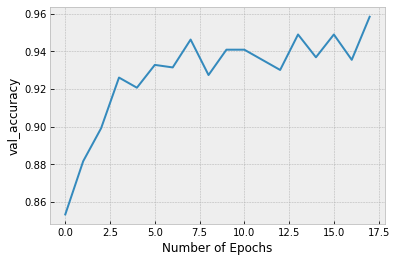

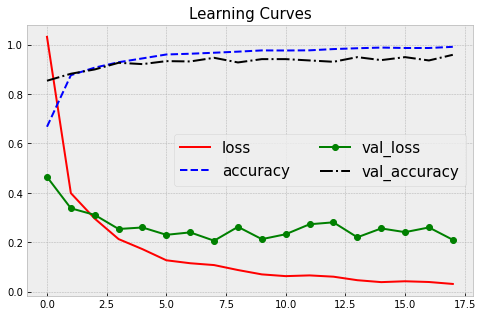

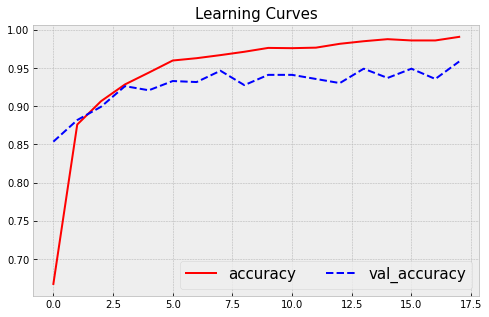

In [7]:
train()